### Neural Network Demo - Image Classifier

A python implementation of [Andrew Ng's neural network algorithm](https://www.coursera.org/learn/machine-learning/home/week/5) - classic, from-scratch implementation.

Resources:
1. [Katherine Bailey's post, 'Neural Nets in Python'](https://katbailey.github.io/post/neural-nets-in-python/)
2. [Keon Yong Lee's post, 'Deep Learning by Andrew Ng â€” Course 1: Neural Networks and Deep Learning'](https://medium.com/@keonyonglee/bread-and-butter-from-deep-learning-by-andrew-ng-course-1-neural-networks-and-deep-learning-41563b8fc5d8)
3. [Benjamin Lau's post, 'Andrew Ng's Machine Learning Course in Python'](https://towardsdatascience.com/andrew-ngs-machine-learning-course-in-python-neural-networks-e526b41fdcd9)

Later, may also implement a neural network for image classification using [TensorFlow](https://www.tensorflow.org/tutorials/images/classification)

In [105]:
from math import *
import numpy as np
import scipy.io as sio #use to import matlab dataset
from sklearn.model_selection import train_test_split #note, this differs from Katherine Bailey's code: sklearn.cross_validation
import matplotlib.pyplot as plt #note, using pyplot instead of pylab

In [8]:
#load dataset - 5000 handwritten digits between 0 and 9
mat_contents = sio.loadmat('data-ex4/ex4data1.mat')

In [120]:
# extract y labels:
# 0s were converted to 10s in the matlab data because matlab
# indices start at 1, so we need to change them back to 0s
y = mat_contents['y'] #a numpy ndarray
y = np.where(y == 10, 0, y)
print('size: ',y.shape)
y

size:  (5000, 1)


array([[0],
       [0],
       [0],
       ...,
       [9],
       [9],
       [9]], dtype=uint8)

In [121]:
#take the transform of the y labels - converts from column to row vector
y = y.reshape((y.shape[0],)) 
y

array([0, 0, 0, ..., 9, 9, 9], dtype=uint8)

In [122]:
X = mat_contents['X']
X.shape

(5000, 400)

In [123]:
#split data: 70% data for training, 30% for testing:
X_train, X_test, y_train, y_test = train_test_split(mat_contents['X'], y,test_size=0.3,random_state=10) 
print('No. training examples:',y_train.shape[0])
print('No. test examples:', y_test.shape[0])

No. training examples: 3500
No. test examples: 1500


In [ ]:
## define a cross-validation set? come back to this
#X_train, X_val = X_train[:-1000], X_train[-1000:]
#y_train, y_val = y_train[:-1000], y_train[-1000:]

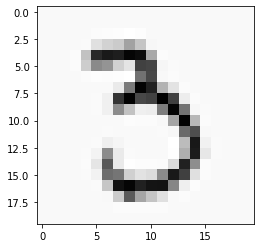

In [124]:
#inspect one of the X examples
plt.imshow(X_train[1301].reshape((20, 20), order='F'), cmap='Greys',  interpolation='nearest')

In [44]:
#use minimize function to optimize theta parameters - NEED THIS?
from scipy.optimize import minimize

### Implement a basic neural network

In [125]:
def sigmoid(X):
    '''Basic sigmoid function for logistic regression.'''
    return 1.0 / (1.0 + e ** (-1.0 * X)) 

In [126]:
def addBias(X):
    '''Adds the bias column to the matrix X'''
    return np.concatenate((np.ones((X.shape[0],1)), X), 1) 

In [127]:
def randInitializeWeights(L_in, L_out):
    '''Randomly initializes the weights for layer with the specified numbers of input and output nodes.'''
    #Randomly initialize the weights to small values
    epsilon_init = 0.1
    #generate random normal distribution with a mean of 0.5
    W = np.random.normal(0.5,size=(L_out, 1 + L_in)) * (2 * epsilon_init) - epsilon_init
    return W

In [128]:
def createInitialWeights(input_layer_size, hidden_layer_size, num_labels):
    '''Returns a single vector of randomly initialized theta1, theta2 parameters (weights) for the
    input layer and hidden layer.'''
    theta1 = randInitializeWeights(input_layer_size, hidden_layer_size)
    theta2 = randInitializeWeights(hidden_layer_size, num_labels)
    return np.append(theta1.ravel(order='A'), theta2.ravel(order='A'))

In [129]:
def reshapeThetaMatrices(thetas, input_layer_size, hidden_layer_size, num_labels):
    '''Reshapes the two theta matrices from a single vector, given the
    size of the input layer, the hidden layer, and the number of
    labels in the output.'''
    theta1size = (input_layer_size + 1) * hidden_layer_size
    theta1 = np.reshape(thetas[:theta1size], (hidden_layer_size, input_layer_size + 1), order='A')
    theta2 = np.reshape(thetas[theta1size:], (num_labels, hidden_layer_size + 1), order='A')
    return theta1, theta2

In [130]:
def oneHotEncode(y, num_classes):
    '''Converts y vector of labels via one-hot encoding to matrix of classes'''
    y = y.reshape((y.shape[0],1))
    ycols = np.tile(y, (1, num_classes))
    m, n = ycols.shape
    indices = np.tile(np.arange(num_classes).reshape((1,num_classes)), (m, 1))
    ymat = indices == ycols
    return ymat.astype(int)

In [131]:
#Test oneHotEncode function
oneHotEncode(y,10)

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 1]])

### Train neural network with forward propagation, prediction, cost calculation, back propagation, update of parameters

In [ ]:
def train(X_train, y_train, num_labels, hidden_layer_size, lmda, maxIter):
    '''Trains a basic neural network, assuming 3 layers: input, hidden, output. 
    Returns parameters (weights) to use to predict new data.'''
    input_layer_size = X_train.shape[1]
    initial_weights = createInitialWeights(input_layer_size, hidden_layer_size, num_labels)
    
    if y_train.ndim == 1:
        # Convert the y labels to one-hot vectors.
        y_train = oneHotEncode(y_train, num_labels)

    ## reshapeThetaMatrices? 
    
    def getActivations(theta1, theta2):
        '''Given theta parameters for the input layer and hidden layer, calulate the 
        activation values for the hidden layer (a2) and the output layer (a3).'''
        a1 = addBias(X_train)
        z2 = np.dot(a1,theta1.T)
        a2 = np.concatenate((np.ones((z2.shape[0],1)), sigmoid(z2)), 1)
        # a2 is an m x num_hidden+1 matrix, Theta2 is a num_labels x
        # num_hidden+1 matrix
        z3 = np.dot(a2,theta2.T)
        a3 = sigmoid(z3) # Now we have an m x num_labels matrix
        return a2, a3
    
    def costFunction(thetas):
        '''Cost function to be minimized with respect to weights.'''
        m = X_train.shape[0]
        
        theta1, theta2 = reshapeThetaMatrices(thetas, input_layer_size, hidden_layer_size, num_labels)
        a2, a3 = getActivations(theta1, theta2)
        
        h = a3 #hypothesis
        
        #calculate cost without regularization
        cost = (1/m) * np.sum((-y_train * np.log(h)) - ((1 - y_train) * np.log(1-h))) #note np.sum is required here rather than sum
        
        
        # Regularization
        #NOTE, not including the bias first columns for each theta matrix
        thetasq = np.sum(theta1[:,1:(input_layer_size + 1)]**2) + np.sum(theta2[:,1:hidden_layer_size + 1]**2)
        reg = (lmda /(2.*m)) * thetasq
        reg_cost = cost + reg
        print("Training loss:\t\t{:.6f}".format(cost))
        return reg_cost
    
    
    def calculateGradient(thetas):
        '''Gradient function to pass to our optimization function.'''
        m = X_train.shape[0]
        theta1, theta2 = extractWeightMatrices(weights, input_layer_size, hidden_layer_size, num_labels)
        # Backpropagation - step 1: feed-forward.
        a2, a3 = getActivations(theta1, theta2)
        
        # calc delta_3 - the delta error in the output layer is just the difference
        # between the output layer, a3, and y
        delta_3 = a3 - y_train # delta_3 is m x num_labels
        delta_3 = delta_3.T

        # calc delta_2
        sigmoidGrad = a2 * (1 - a2)
        delta_2 = (np.dot(theta2.T,delta_3)) * sigmoidGrad.T
        delta_2 = delta_2[1:, :] # hidden_layer_size x m. note first column is excluded because the hidden layer bias unit has no connection to the input layer - so we do not use backpropagation for it.
        
        #Accumulate errors into Delta matrices
        theta1_grad = np.dot(delta_2, np.concatenate((np.ones((X_train.shape[0],1)), X_train), 1)) #delta2 * a1(X with a column of ones)
        theta2_grad = np.dot(delta_3, a2) #delta3 * a2
        
        # Add regularization
        reg_grad1 = (lmda / float(m)) * theta1
        # We don't regularize the weight for the bias column
        reg_grad1[:,0] = 0
        
        reg_grad2 = (lmda / float(m)) * theta2;
        reg_grad2[:,0] = 0
        
        theta1_grad = ravel((theta1_grad / float(m)) + reg_grad1, order='A') #np.ravel 'flat-packs an array into 1D'
        theta2_grad = ravel((theta2_grad / float(m)) + reg_grad2, order='A')
        #return a 1D combined array of both gradients
        return np.append(theta1_grad,theta2_grad)
    
    
    
    # START HERE...

In [145]:
# code below is testing the individual functions above
input_layer_size = X_train.shape[1]
hidden_layer_size=25
lmda = 2
print(input_layer_size,hidden_layer_size)

400 25


In [94]:
thetas = createInitialWeights(400, 25, 10)
theta1,theta2=reshapeThetaMatrices(thetas, 400, 25, 10)

In [95]:
a1 = addBias(X_train)
z2 = np.dot(a1,theta1.T)

In [100]:
a2 = np.concatenate((np.ones((z2.shape[0],1)), sigmoid(z2)), 1)
z3 = np.dot(a2,theta2.T)
a3 = sigmoid(z3) # Now we have an m x num_labels matrix

In [109]:
    if y_train.ndim == 1:
        # Convert the y labels to one-hot vectors.
        y_train = oneHotEncode(y_train, 10)

In [138]:
m = X_train.shape[0]
h=a3
J = (1/m) * np.sum((-y_train * np.log(h)) - ((1 - y_train) * np.log(1-h)))

In [139]:
J 

6.2725784005396195

In [143]:
thetasq = np.sum(theta1[:,1:(input_layer_size + 1)]**2) + np.sum(theta2[:,1:hidden_layer_size + 1]**2)
thetasq

414.82801625185857

In [153]:
lmda = 2
reg = (lmda /(2*m)) * thetasq
cost = J + reg
print("Training loss:\t\t{:.6f}".format(cost))

Training loss:		6.391101


In [158]:
        # calc delta_3 - the delta error in the output layer is just the difference
        # between the output layer, a3, and y
        delta_3 = a3 - y_train # delta_3 is m x num_labels
        delta_3 = delta_3.T

        # calc delta_2
        sigmoidGrad = a2 * (1 - a2)
        delta_2 = (np.dot(theta2.T,delta_3)) * sigmoidGrad.T
        delta_2 = delta_2[1:, :] # hidden_layer_size x m. note first column is excluded because the hidden layer bias unit has no connection to the input layer - so we do not use backpropagation for it.
        
        #Accumulate errors into Delta matrices
        theta1_grad = np.dot(delta_2, np.concatenate((np.ones((X_train.shape[0],1)), X_train), 1)) #delta2 * a1(X with a column of ones)
        theta2_grad = np.dot(delta_3, a2) #delta3 * a2
        
        # Add regularization
        reg_grad1 = (lmda / float(m)) * theta1
        # We don't regularize the weight for the bias column
        reg_grad1[:,0] = 0
        
        reg_grad2 = (lmda / float(m)) * theta2;
        reg_grad2[:,0] = 0
        
        theta1_grad = np.ravel((theta1_grad / float(m)) + reg_grad1, order='A') 
        theta2_grad = np.ravel((theta2_grad / float(m)) + reg_grad2, order='A')

In [159]:
theta1_grad

array([-4.93763090e-03, -1.44216197e-04, -2.33366989e-05, ...,
       -2.10759087e-04,  9.25626012e-05, -1.86607735e-04])

In [160]:
np.append(theta1_grad,theta2_grad)

array([-4.93763090e-03, -1.44216197e-04, -2.33366989e-05, ...,
        9.81530413e-02,  1.49853804e-01,  1.41802847e-01])